In [1]:
from pvc_tensile_experiment.Functions import *; 
import matplotlib.pyplot as plt; import numpy as np

# set folder name and directory
folderName = 'Data/PVC P4 Test_0'

# set limits for the search region
smalls = 100
bigs = 2000
openingKernal = np.ones((5,5), np.uint8)

# show the area of the centroids
MarkerIdentify(folderName, smalls, bigs, openingKernal)

# find the tracked particles
tracked = ParticleIdentify(folderName, smalls, bigs, openingKernal)

# process the data and compile, getting strain and stress calculations 
axDist, axStrain, transDist, transStrain, stress, specimenCenterLine, axialAngleOffset  = StrainFunction(folderName, tracked)

# plot the angle 
plt.figure(0)
plt.plot(np.rad2deg(axialAngleOffset),'-r', linewidth = 1, label = 'Axial Centerline')
plt.plot(np.rad2deg(specimenCenterLine), linewidth = 1, label = 'Speciemen Centerline')
plt.xlabel('Frame')
plt.ylabel('Angle (Degree)')
plt.title('Centerline Offset Angle')
plt.legend()
plt.show()

747.0
334.5
478.5
556.5
1956.5
1247.5
1012.5
1706.0


C:\Users\facci\OneDrive\Documents\Programming fun\PVC Tensile Experiment\src\pvc_tensile_experiment\Functions.py:162: SyntaxWarning: invalid escape sequence '\{'
  df.to_csv(f"Processed data\{testName}.csv", sep = ',', header = True, index = False)


KeyboardInterrupt: 

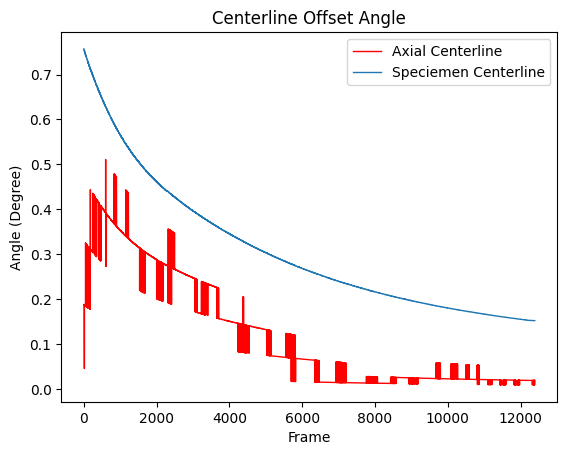

In [6]:
# plot the angle 
plt.figure(0)
plt.plot(np.rad2deg(axialAngleOffset),'-r', linewidth = 1, label = 'Axial Centerline')
plt.plot(np.rad2deg(specimenCenterLine), linewidth = 1, label = 'Speciemen Centerline')
plt.xlabel('Frame')
plt.ylabel('Angle (Degree)')
plt.title('Centerline Offset Angle')
plt.legend()
plt.show()

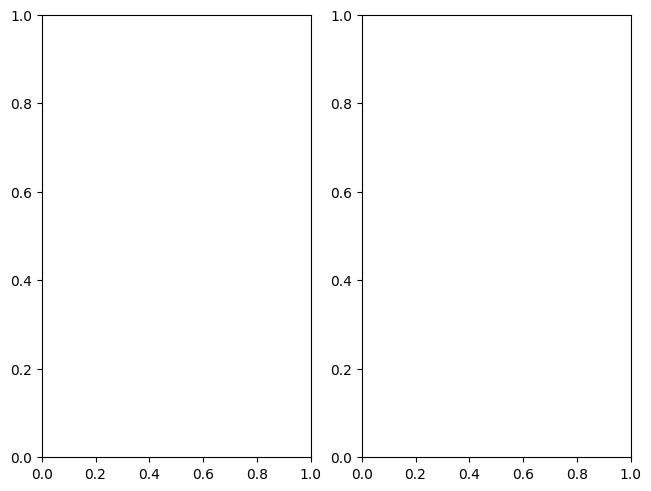

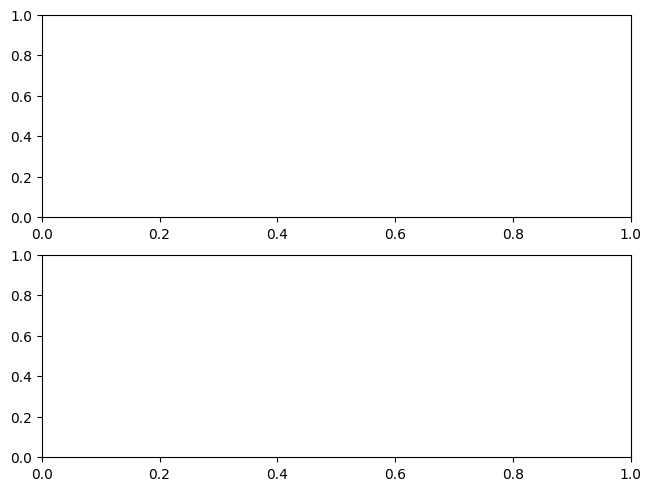

In [ ]:
"""Overlay the individual processed data set on a plot"""
from Functionsd import DataReader
import os; import matplotlib.pyplot as plt
import numpy as np

# the desired plasticizer ratio 
plastiRatio = 'P2'

# list the processed file names
fileNames = [i for i in os.listdir('Processed data') if i.find(f'{plastiRatio}') != -1]

# preallocate the suplots
fig, axs = plt.subplots(1,2, layout = "constrained")
fig, axs1 = plt.subplots(2,1, layout = "constrained")

for i in fileNames:
    name = i.removesuffix('.csv')
    axDist, axStrain, transDist, transStrain, stress, specimenCenterLine, axialAngleOffset = DataReader(i)
    
    # account for angular corrections of the markers and specimen
    axStrainCorrected = axStrain*np.cos(axialAngleOffset)
    transStrainCorrected = transStrain*np.cos(axialAngleOffset)
    stressCorrected = stress*np.cos(specimenCenterLine)

    # find true strain and stress from engineering strain
    stretchRatio = 1 + axStrainCorrected
    axStrainTrue = np.log(stretchRatio) 
    stressTrue = stressCorrected*stretchRatio

    # plot the engineering axial and transverse strain per frame
    axs[0].plot(axStrainCorrected, label = f'{name} Axial Strain')
    axs[0].plot(transStrainCorrected, label = f'{name} Transverse Strain')
    axs[1].plot(transStrainCorrected, axStrainCorrected, label = f'{name} Strains' )
    axs[0].set_xlabel('Frame')
    axs[1].set_xlabel('Transverse Strain (pxl/pxl)')
    axs[0].set_ylabel('Strain (pxl/pxl)')
    axs[1].set_ylabel('Axial Strain (pxl/pxl)')
    axs[0].legend(fontsize = 6)
    axs[1].legend(fontsize = 8)

    # plot engineering (first piola) stress vs strain
    axs1[0].plot(stretchRatio, stressCorrected, label = f'{name}')   
    axs1[1].plot(axStrainTrue, stressTrue, label = f'{name}')
    axs1[0].set_xlabel('Stretch Ratio (pxl/pxl)')
    axs1[1].set_xlabel('True Axial Strain (pxl/pxl)')
    axs1[0].set_ylabel('Stress (MPa)')
    axs1[1].set_ylabel('Stress (MPa)')
    axs1[0].set_title('Engineering Stress-Strain')
    axs1[1].set_title('True Stress-Strain')
    axs1[0].legend(fontsize = 8)
    axs1[1].legend(fontsize = 8)

plt.show()


In [ ]:
"""Combined elastic modulus and poissons ratio"""
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt; import numpy as np
from Functionsd import *
import pandas as pd

def LinearFit(x, a, b):
    return a*x + b

# define the plasticizer ration we want
plastiRatio = 'P4'

# compile all the data  
axDist, axStrain, transDist, transStrain, stress, specimenCenterLine, axialAngleOffset = DataComplile(plastiRatio)



# account for angular corrections of the markers and specimen
axStrainCorrected = axStrain*np.cos(axialAngleOffset)
transStrainCorrected = transStrain*np.cos(axialAngleOffset)
stressCorrected = stress*np.cos(specimenCenterLine)

# find true strain and stress from engineering strain
stretchRatio = 1 + axStrainCorrected
secThrStretchRatio = 1/np.sqrt(stretchRatio)
axStrainTrue = np.log(stretchRatio) 
stressTrue = stressCorrected*stretchRatio

df = pd.DataFrame(columns = ["Strain", "Stress"])
df["Strain"] = axStrainTrue
df["Stress"] = stress
df.to_csv(f"crap.csv", sep = ',', header = True, index = False)



# define the elastic region
elasRegion = [list(axStrainCorrected).index(i) for i in axStrainCorrected if i < 0.2 and i > 0.05]
elasAxStrain = axStrainCorrected[elasRegion]
elasTransStrain = transStrainCorrected[elasRegion]
elasStress = stressCorrected[elasRegion]

# curve fit the elastic region. find the 
xfit = np.linspace(elasAxStrain[0], elasAxStrain[-1])
poptE, pcovE = curve_fit(LinearFit, elasAxStrain, elasStress)
poptP, pcovP = curve_fit(LinearFit, elasAxStrain, elasTransStrain)


# plot engineering stress vs strain
plt.figure(0)
plt.scatter(elasAxStrain, elasStress)
plt.plot(xfit, LinearFit(xfit, poptE[0], poptE[1]), 'r')
plt.xlabel('Axial Strain (pxl/pxl)')
plt.ylabel('Stress (MPa)')
plt.title('Elastic Modulus')
plt.show()

# plot poissons ratio
plt.figure(1)
plt.scatter(elasAxStrain, elasTransStrain)
plt.plot(xfit, LinearFit(xfit, poptP[0], poptP[1]), 'r')
plt.xlabel('Axial Strain (pxl/pxl)')
plt.ylabel('Transverse Strain (pxl/pxl)')
plt.title('Poissons Ratio')
plt.show()

In [ ]:
"""Read the individual processed data sets"""
from Functionsd import DataReader
axDist, axStrain, transDist, transStrain, stress, specimenCenterLine, axialAngleOffset = DataReader('PVC P4 Test_1.csv')

Fitted Arruda-Boyce parameters: mu = 0.4197904186355352, N = 3.0118459104601087


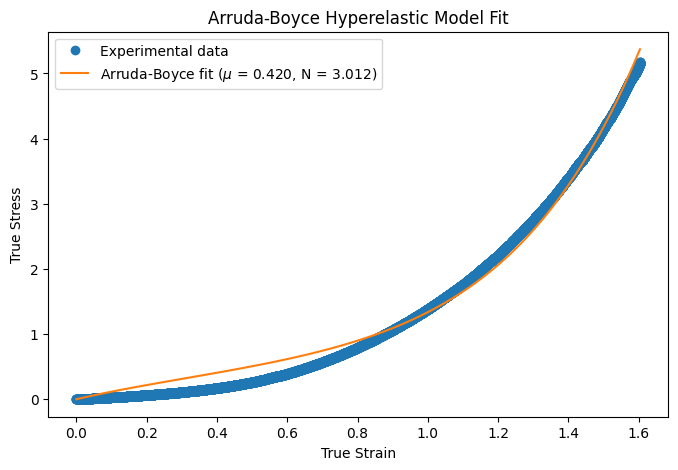

In [3]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Sample uniaxial stress and strain data (replace these arrays with your actual data)
true_strain = axStrainTrue # True strain values
stress = stressTrue     # True stress values

# Define the Arruda-Boyce model function for uniaxial stress
def arruda_boyce_model(strain, mu, N):
    # Calculate the stretch ratio, lambda
    lambda_ = 1 + strain
    I1_bar = lambda_**2 + 2 / lambda_

    # Arruda-Boyce uniaxial stress-strain relationship
    return (mu / lambda_) * (lambda_**2 - 1 / lambda_) * (
        1 + (3 / 5) * ((I1_bar - 3) / N) +
        (99 / 175) * ((I1_bar - 3) / N)**2 +
        (513 / 875) * ((I1_bar - 3) / N)**3
    )

# Perform the curve fitting
popt, pcov = curve_fit(arruda_boyce_model, true_strain, stress, p0=[1.0, 5.0])

# Extract the fitted parameters
mu_fitted, N_fitted = popt
print(f"Fitted Arruda-Boyce parameters: mu = {mu_fitted}, N = {N_fitted}")

# Plotting the data and the fitted curve
strain_fit = np.linspace(min(true_strain), max(true_strain), 100)
stress_fit = arruda_boyce_model(strain_fit, mu_fitted, N_fitted)

plt.figure(figsize=(8, 5))
plt.plot(true_strain, stress, 'o', label='Experimental data')
plt.plot(strain_fit, stress_fit, '-', label=f'Arruda-Boyce fit ($\mu$ = {mu_fitted:.3f}, N = {N_fitted:.3f})')
plt.xlabel("True Strain")
plt.ylabel("True Stress")
plt.legend()
plt.title("Arruda-Boyce Hyperelastic Model Fit")
plt.show()

